# Geolocation knowledge: AOCS performance analysis

Thia notebook starts with the MRD requirement on geolocation knowledge:

![MRD-GEO-0040](MRD-GEO-0040.png)  (from MRD)

It illustartes the interface of TEDS with AOCS simulation that is needed for MRD-> SRD flowdown, and platform performance analysis.  

For TANGO E2E simulations geolocation is simulated as part fo two modules:
+ Using simulated or external navigation data (AOCS), the GM calculates the geolocations of the intersect of the ACT line of sights with the surface. The geolocation and the navigation data are provided as GM output. (In case of AOCS data, navigation data are not changed.)
+ The L1A-L1B processor determines te geolocation of the L1B pixel. Here the same routine is used, requing navigation and ckd data as input. The geolocation data of the L1B product are not affected by any other operation within an E2ES chain.

Due to this, the sensitivity of geolocation with respect to peturbed navigation data can be depermined by the following setup:

![notebook_flow](geolocation_analysis.jpg)

This tutorial requires auxiliary files which are available at the TANGO ftp site (ftp.sron.nl). 

* Calibration key data containing the line-of-sight (LOS) vectors, e.g.`ckd_ACT100_date.nc`
* Digital elevation model (DEM) with surface heights covering the whole Earth with 15-arcsecond steps. `gebco_ocssw_v2020.nc` This is an optional input to geolocation for better accuracy.
* True navigation data from AOCS simulations. `aocs_navigation_truth.nc`Used as input for GM instead of the SGP4 library.
* Perturbed navigation data from AOCS with realistic perturbations on the attitude quaternions `aocs_navigation_perturbed.nc`tamps remain the same as in the truth case. 
* World coastline map for plotting from Natural Earth (https://www.naturalearthdata.com/)

Remark: Do not forget to set the PYTHON PATH` (`sys.path`) to point to the TEDS source directory and activate the TEDS virtual environment. 

## 1. Set up the working environment

In [ ]:
import sys
import os
import yaml
# Add TEDS source directory and the Python virtual environment to PYTHONPATH
sys.path.append("/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/")
os.chdir("/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/examples/exp12_geometry/")

from datetime import datetime
from netCDF4 import Dataset
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import yaml

from teds.gm.gm import geometry_module
from teds.gm.vincenty import vincenty

## 2. Generate geometry using TEDS
To demonstrate the GM funtionality, we start to generate our own navigation data using the configuration in the yaml file gm_config.yaml. It gives a configuration for generating navigation and geolocation data over a 30x30 km2 area around the Janschwalde power plant. We need to specify the dwell time (how long it takes to collect radiation at each bin) and take LOS vectors from the CKD in order to generate a realistic latitude/longitude grid (part of geolocation data). No forward motion compensation is modelled here (FMC=1) which sets the dwell time to 42.5 ms. The total image capture period is 4.2 s. Generation of navigation data does not depend on instrument parameters.

In [2]:
config = yaml.safe_load(open('./settings/gm_config.yaml'))
print(config)
geometry_module(config)

[13:31:04] Generating detector image timestamps
[13:31:04] Generating orbit timestamps
[13:31:04] Generating satellite orbit


{'profile': 'orbit', 'orbit': {'epoch': datetime.datetime(2022, 8, 12, 12, 0), 'sat_height': 500.0, 'eccentricity': 0.0, 'arg_perigee': 0.0, 'mean_anomaly': 0.0, 'ltan': 13.823, 'mean_motion_dot': 0.0, 'drag_coeff': 0.0, 'propagation_duration': 0.25}, 'sensor': {'dwell_time': 0.0425, 'start_time': 13.73, 'end_time': 13.8}, 'io_files': {'ckd': '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/ckd/ckd_ACT100_20250126.nc', 'dem': '/home/jochen/TANGO_E2ES/EndtoEndProject/data/dem/gebco_ocssw_v2020_uncompressed.nc', 'geometry': '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/gm/geometry_exp12.nc', 'navigation': '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/gm/navigation_exp12.nc'}}
#########################
# Tango geometry module #
#########################
Version                 : 0.0.1
Commit hash             : 6afe7ff4
Date and timezone       : 2025 February 09 Sun
Contacts                : raullaasner@gmail.com
                          bitbucket

[13:31:06] Generating attitude quaternions
[13:31:06] Geolocation



###########
# Success #
###########


In order to visualize the entire simulated trajectory of the spacecraft, perform another simulation by artificially increasing the dwell time and the image capture period and then only look at the swath center latitudes and longitudes along the track. The instrument parameters have no meaning here --- this is just to get the ground track.

In [17]:
config['sensor'] = {
    'dwell_time': 1.0,  # seconds
    'start_time': 0.0,  # minutes wrt orbit epoch
    'end_time': 14.8,  # minutes wrt orbit epoch
}
config['io_files']['geometry'] = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/gm/geometry_full_exp12.nc'
geometry_module(config)

[17:04:08] Generating detector image timestamps


#########################
# Tango geometry module #
#########################
Version                 : 0.0.1
Commit hash             : 6afe7ff4
Date and timezone       : 2025 February 09 Sun
Contacts                : raullaasner@gmail.com
                          bitbucket.org/sron_earth/teds/issues (request permission)
Host system             : Linux 6.8.0-52-generic



[17:04:08] Generating orbit timestamps
[17:04:08] Generating satellite orbit
[17:04:10] Generating attitude quaternions
[17:04:10] Geolocation



###########
# Success #
###########


Now plot the ground track and the geolocation data in one figure. This is just to visualize the scene. The usage of GM products in other TEDS modules is as follows:
* `geometry.nc` --- latitudes and longitudes and the solar and viewing geometries. Used in the scene generation module (SGM) for generating a radiometric scene.
* `navigation.nc` --- navigation data (orbit positions and attitudes quaternions) used in the L1B processor for rederiving geolocation data.

(51.65, 52.0)

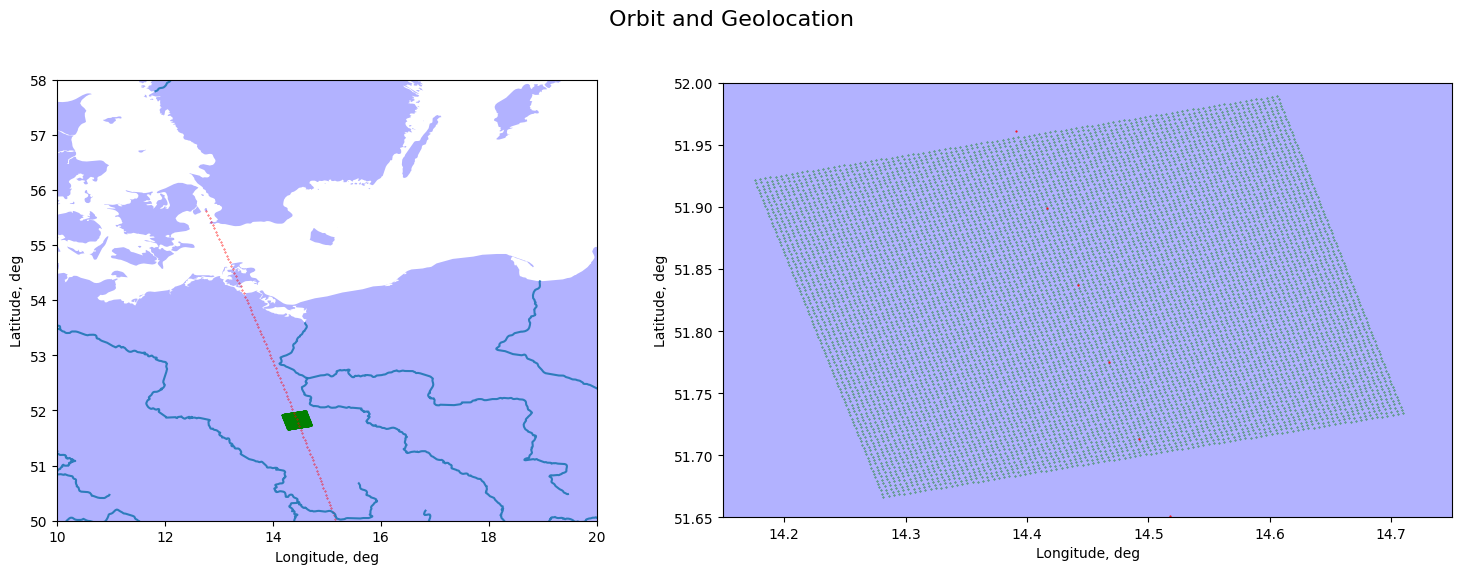

In [25]:
#nc = Dataset('geometry.nc')
nc = Dataset('/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/gm/geometry_exp12.nc')
lat, lon = nc['longitude'][:].data, nc['latitude'][:].data
nc.close()

#nc = Dataset('geometry_full.nc')
nc = Dataset('/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/gm/geometry_full_exp12.nc')
lat_mid, lon_mid = nc['longitude'][:].data, nc['latitude'][:].data
i_mid = lat_mid.shape[1] // 2
lat_mid, lon_mid = lat_mid[:, i_mid], lon_mid[:, i_mid]
nc.close()

fig, axs = plt.subplots(1, 2, figsize=(18, 6), dpi=100, width_ratios=[1, 1.35])
fig.suptitle(f'Orbit and Geolocation', fontsize=16,)
ax1 = axs[0]
world = gpd.read_file('/home/jochen/TANGO_E2ES/EndtoEndProject/data/NaturalEarth/10m_physical/ne_10m_land.shx')
river_lakes  = gpd.read_file('/home/jochen/TANGO_E2ES/EndtoEndProject/data/NaturalEarth/10m_physical/ne_10m_rivers_lake_centerlines.shx')
world.plot(ax=ax1, alpha=0.3, color = 'blue')
river_lakes.plot(ax=ax1, alpha=0.9)
ax1.set_xlabel('Longitude, deg')
ax1.set_ylabel('Latitude, deg')
ax1.scatter(lat, lon, s=0.1, c='g')
ax1.scatter(lat_mid, lon_mid, s=0.1, c='red')
ax1.set_xlim(10, 20)
ax1.set_ylim(50, 58)

ax1 = axs[1]
world = gpd.read_file('/home/jochen/TANGO_E2ES/EndtoEndProject/data/NaturalEarth/10m_physical/ne_10m_land.shx')
river_lakes  = gpd.read_file('/home/jochen/TANGO_E2ES/EndtoEndProject/data/NaturalEarth/10m_physical/ne_10m_rivers_lake_centerlines.shx')
world.plot(ax=ax1, alpha=0.3, color = 'blue')
river_lakes.plot(ax=ax1, alpha=0.9)
ax1.set_xlabel('Longitude, deg')
ax1.set_ylabel('Latitude, deg')
ax1.scatter(lat, lon, s=0.1, c='g')
ax1.scatter(lat_mid, lon_mid, s=0.3, c='red')
ax1.set_xlim(14.15, 14.75)
ax1.set_ylim(51.65, 52)

## 2. Generate geometry using AOCS navigation data
The "orbit" section in the configuration file gives us the freedom to target any area of interest. On the other hand, if navigation data from the AOCS orbit simulator for a particular scene is available, it can instead be used as input for GM, bypassing the generation of navigation data using the SPG4 library routines. The advantage of using AOCS is the couping of TEDS to external AOCS tools for more realistic TANGO orbit simulations based on platform parameters. For example, AOCS is capable or producing attitude quaternions with or without perturbations specific to the Tango platform.

In the yaml file `gm_config_AOCS.yaml`, the "aocs_navigation" keyword pointing to a file containing the AOCS navigation data. We start with the truth case. Notice that the entire "orbit" section is gone because it is not needed in this case. The navigation data is modelled for FMC=5 which sets the dwell time to 212.4 ms. `start_time` refers to the beginning of the navigation data and `end_time` is set to 19.8 s (0.33 min) which is about 5 times longer than the first simulation. This is because the FMC=5 condition results in a small rotation of the platform in order to stay more focused on the target scene. Thus, in order to cover the same 30 km ground distance along track as before, the image capture time needs to be longer.

In [ ]:
config = yaml.safe_load(open('./settings/gm_aocs_config.yaml'))

geometry_module(config)

[17:26:54] Reading AOCS generated quaternions
[17:26:54] Generating detector image timestamps
[17:26:54] Generating orbit timestamps
[17:26:54] Geolocation


{'profile': 'orbit', 'sensor': {'dwell_time': 0.2124, 'start_time': 0.0, 'end_time': 0.33}, 'io_files': {'aocs_navigation': '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/aocs/aocs_navigation_truth.nc', 'ckd': '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/ckd/ckd_ACT100_20250126.nc', 'dem': '/home/jochen/TANGO_E2ES/EndtoEndProject/data/dem/gebco_ocssw_v2020_uncompressed.nc', 'geometry': '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/gm/geometry_aocs_true_exp12.nc', 'navigation': '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/gm/navigation_exp12.nc'}}
#########################
# Tango geometry module #
#########################
Version                 : 0.0.1
Commit hash             : 6afe7ff4
Date and timezone       : 2025 February 09 Sun
Contacts                : raullaasner@gmail.com
                          bitbucket.org/sron_earth/teds/issues (request permission)
Host system             : Linux 6.8.0-52-generic


###########

Next, visualize the geolocation data from the first simulation (FMC=1) with that from the AOCS navigation data (FMC=5). Other than a different trajectory of the spacecraft (e.g. orbit inclination), they cover a similar 30x30 km2 area around Janschwalde. The main difference is that the AOCS result has about 5 times as many bins along track.

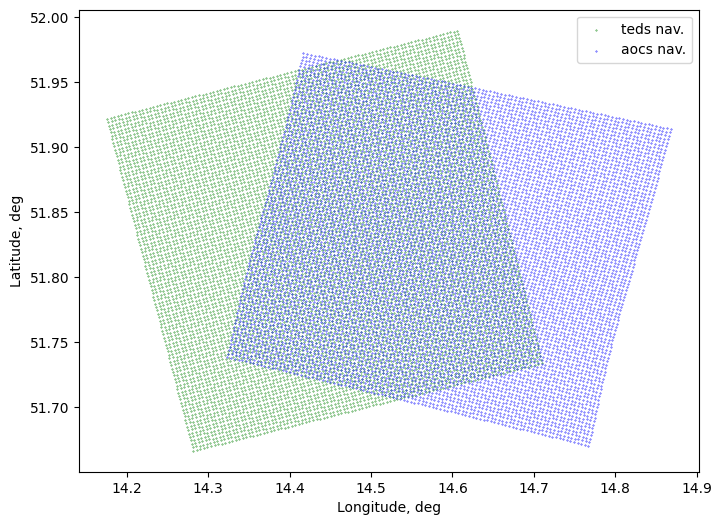

In [32]:
nc = Dataset('/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/gm/geometry_exp12.nc')
lat, lon = nc['longitude'][:].data, nc['latitude'][:].data
nc.close()

nc = Dataset('/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/gm/geometry_aocs_true_exp12.nc')
lat_aocs, lon_aocs = nc['longitude'][:].data, nc['latitude'][:].data
nc.close()

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel('Longitude, deg')
ax.set_ylabel('Latitude, deg')
ax.scatter(lat, lon, s=0.1, c='g', label='teds nav.')
ax.scatter(lat_aocs, lon_aocs, s=0.1, c='b', label='aocs nav.')
plt.legend()

## 3. Peturbed AOCS navigation data
Finally, we redo step 2 but using perturbed attitude quaternions (AOCS navigation data) as input.

In [35]:
config = yaml.safe_load(open('./settings/gm_aocs_config.yaml'))
config['io_files']['aocs_navigation'] = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/aocs/aocs_navigation_perturbed.nc'
config['io_files']['geometry'] = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/gm/geometry_aocs_pet_exp12.nc'
geometry_module(config)

[19:39:42] Reading AOCS generated quaternions
[19:39:42] Generating detector image timestamps
[19:39:42] Generating orbit timestamps
[19:39:42] Geolocation


#########################
# Tango geometry module #
#########################
Version                 : 0.0.1
Commit hash             : 6afe7ff4
Date and timezone       : 2025 February 09 Sun
Contacts                : raullaasner@gmail.com
                          bitbucket.org/sron_earth/teds/issues (request permission)
Host system             : Linux 6.8.0-52-generic


###########
# Success #
###########


## 4. Data analysis in respect of MRD requirement MRD-GEO-0040

Define the geolocation error by computing distances between geolocation points from the truth and perturbed simulations. The error varies little across track which is expected because the simulated perturbations do not have LOS vector dependence. Along track, however, the error ranges from 50 m to 300 m, i.e. up to the extent of 1 L1B bin.

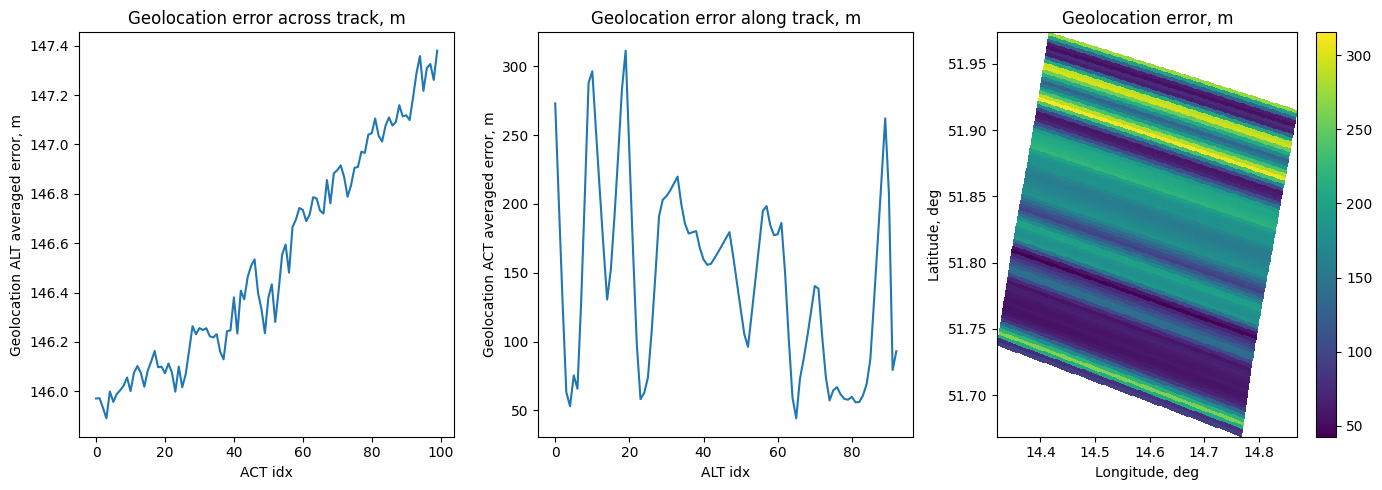

In [36]:
nc = Dataset('/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/gm/geometry_aocs_true_exp12.nc')
lat_truth, lon_truth = nc['longitude'][:].data, nc['latitude'][:].data
nc.close()

nc = Dataset('/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/gm/geometry_aocs_pet_exp12.nc')
lat_pert, lon_pert = nc['longitude'][:].data, nc['latitude'][:].data
nc.close()

distances = vincenty(np.deg2rad(lat_truth), np.deg2rad(lat_pert),
                     np.deg2rad(lon_truth), np.deg2rad(lon_pert))

fig, axs = plt.subplots(1, 3, figsize=(14, 5))

ax = axs[0]
ax.plot(distances.mean(0))
ax.set_xlabel('ACT idx')
ax.set_ylabel('Geolocation ALT averaged error, m')
ax.set_title('Geolocation error across track, m')

ax = axs[1]
ax.plot(distances.mean(1))
ax.set_xlabel('ALT idx')
ax.set_ylabel('Geolocation ACT averaged error, m')
ax.set_title('Geolocation error along track, m')

ax = axs[2]
psm = ax.pcolormesh(lat_truth, lon_truth, distances)
fig.colorbar(psm, ax=ax)
ax.set_xlabel('Longitude, deg')
ax.set_ylabel('Latitude, deg')
ax.set_title('Geolocation error, m')

plt.tight_layout()

Text(0.5, 1.0, 'CE90 =221.3 m ')

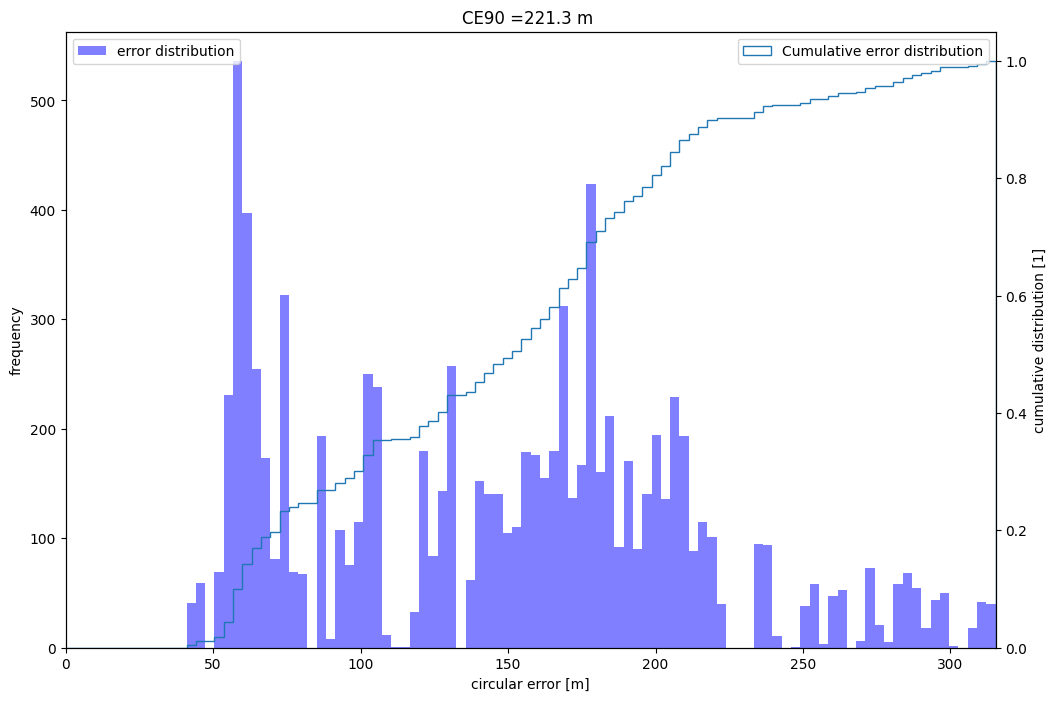

In [71]:
# distribution of circular error and cumulative error distribution

err = distances.flatten()
err_bound = np.max(np.abs(err))

num_bins = 101
bindef = np.arange(num_bins)
bindef = err_bound*bindef/np.max(bindef)

fig, ax1  = plt.subplots(
    1,
    1,
    figsize=(12, 8),
    dpi=100,)

ax1.hist(err,
  bins  = bindef,
  alpha = 0.5,
  color = 'blue',
  label = 'error distribution')
ax1.set_xlabel('circular error [m]')
ax1.set_ylabel('frequency')
ax1.set_xlim(0,err_bound)
ax1.legend(loc = 'upper left')

ax2 = ax1.twinx()
ax2.set_ylabel("cumulative distribution [1]")
ax2.hist(err, 
  bins= bindef, 
  density = True, 
  histtype = "step",
  cumulative = True, 
  label = "Cumulative error distribution")
ax2.legend(loc = 'upper right')

CE90 = np.percentile(err,90.)
plt.title(f"CE90 ={CE90:.1f} m ")

